### Importing the necessary libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import re
import string
import nltk
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Importing the data file

In [189]:
df = pd.read_csv('sample30.csv')

## EDA

we will check the some basic properties of the data we imported

In [190]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [191]:
df.shape

(30000, 15)

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [193]:
#find the percentage of null values in each column to determine columns to be dropped
pd.set_option('display.max_rows', 120) #to display all rows
print(round(100*(df.isnull().sum()/len(df.index)), 2))

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64


Will use some of the features to perform some EDA and later go on with cleaning of the dataset

## Univariate Analysis

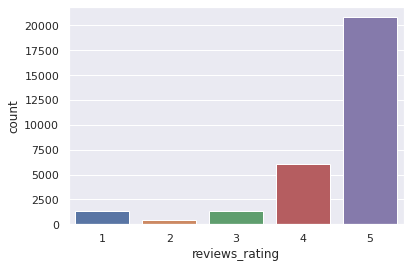

In [194]:
#checking the spread of ratings given by the customers
sns.countplot(x = 'reviews_rating', data = df)
plt.show()

In [195]:
df['reviews_rating'].value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

### So on top of the head we can see that major share of the ratings lies on good side or higher side, thus there is definately a imbalance present in the data.

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [197]:
#Checking the unique brands,manufacturers and categories present in this dataset
print("number of unique brands :        ",len(df['brand'].unique()),'\n'
     "number of unique manufacturers : ",len(df['manufacturer'].unique()),'\n'
     "number of uniquer categories :   ",len(df['categories'].unique()))

number of unique brands :         214 
number of unique manufacturers :  228 
number of uniquer categories :    270


In [198]:
#Function to print the count graph for brands and manufactures, divided the total items in brands having reviews less than
# equal to 10 and more than 10 , same for manufacturers
def plot_graph(df,feature,flag):
     if flag == 0:
         a = df[feature].value_counts()
         a1 = list(a[a.values<=10].index)
         df_temp = df.loc[df[feature].isin(a1)]
         a1_dims = (14, 10)
         fig, fx = plt.subplots(figsize=a1_dims)
         cx = sns.countplot(x = feature, data = df_temp)
         plt.xlabel(feature + ' having reviews less than equal to 10')
         plt.tight_layout()
         plt.xticks(rotation=90)
         plt.tick_params(axis='x', which='major', labelsize=7)
         plt.show()
     else :
         a = df[feature].value_counts()
         a1 = list(a[a.values>10].index)
         df_temp = df.loc[df[feature].isin(a1)]
         a1_dims = (14, 10)
         fig, fx = plt.subplots(figsize=a1_dims)
         cx = sns.countplot(x = feature, data = df_temp, log = True)
         plt.xlabel(feature + ' having reviews more than 10')
         plt.tight_layout()
         plt.xticks(rotation=90)
         plt.tick_params(axis='x', which='major', labelsize=7)
         plt.show()

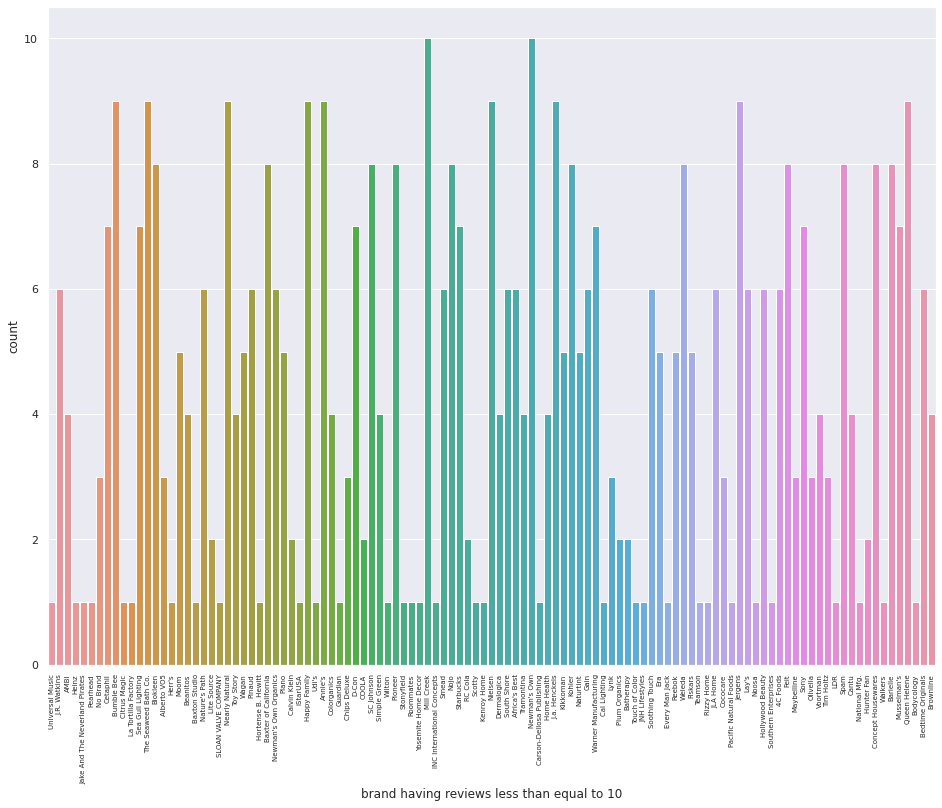

In [199]:
#for brands having reviews less than equal to 10 reviews
plot_graph(df,'brand',0)

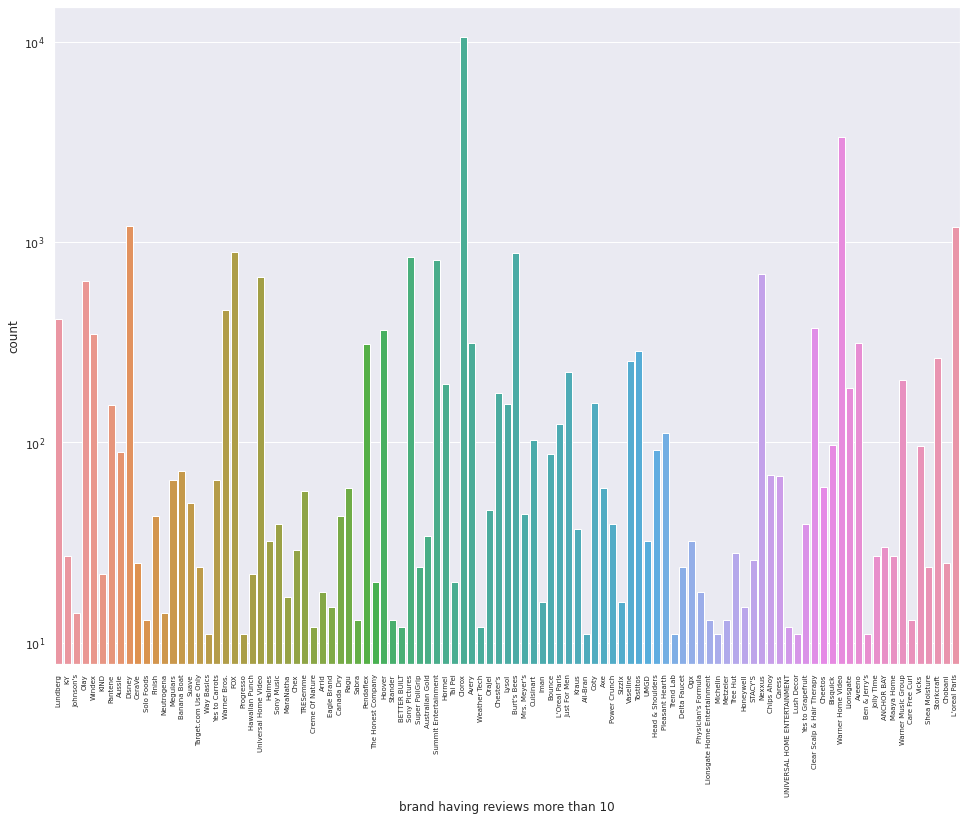

In [200]:
#for brands having reviews more than equal 10 reviews
plot_graph(df,'brand',1)

On seeing the above 2 plots we can see that there is a uniformity in the review counts for the products having less than 11 reviews while the products having review more than 10 there is a high review count for select few brands.

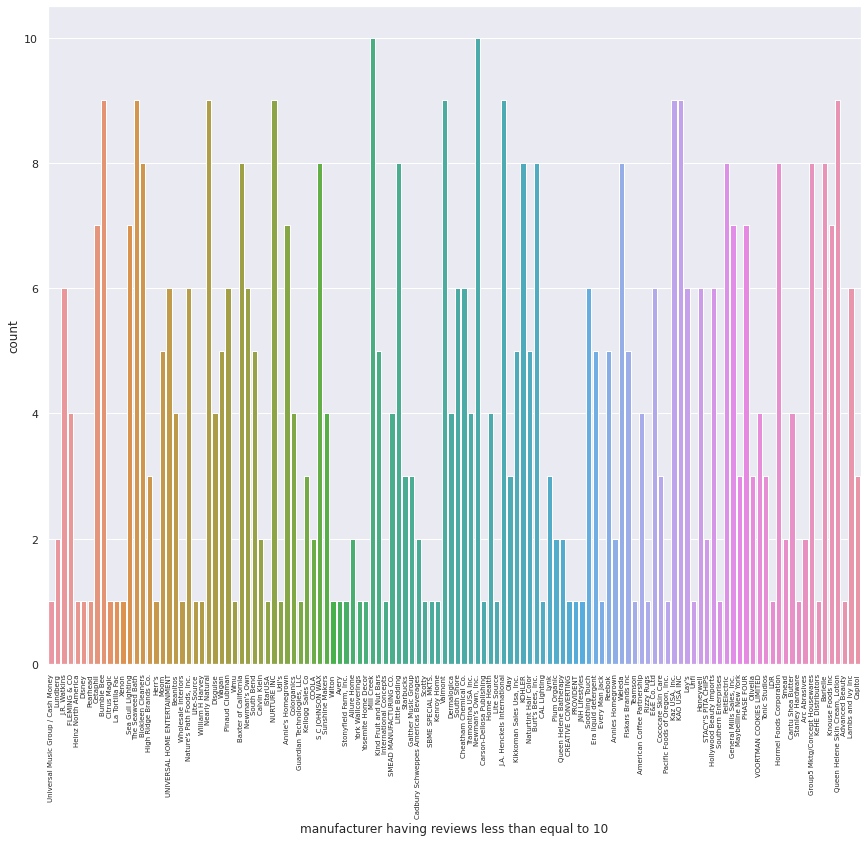

In [201]:
#for manufaturers having reviews less than equal to 10 reviews
plot_graph(df,'manufacturer',0)

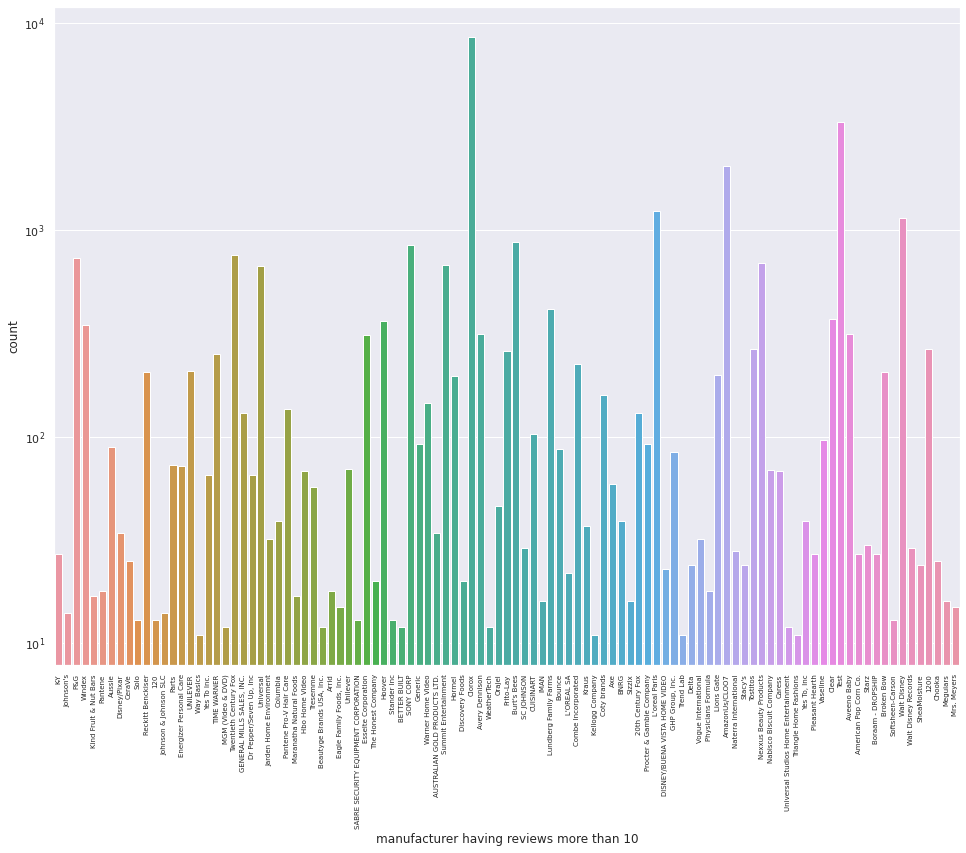

In [202]:
#for brands having reviews more than equal 10 reviews
plot_graph(df,'manufacturer',1)

A similar trend is seen as that of the brands, mostly brands are same as manufacturers

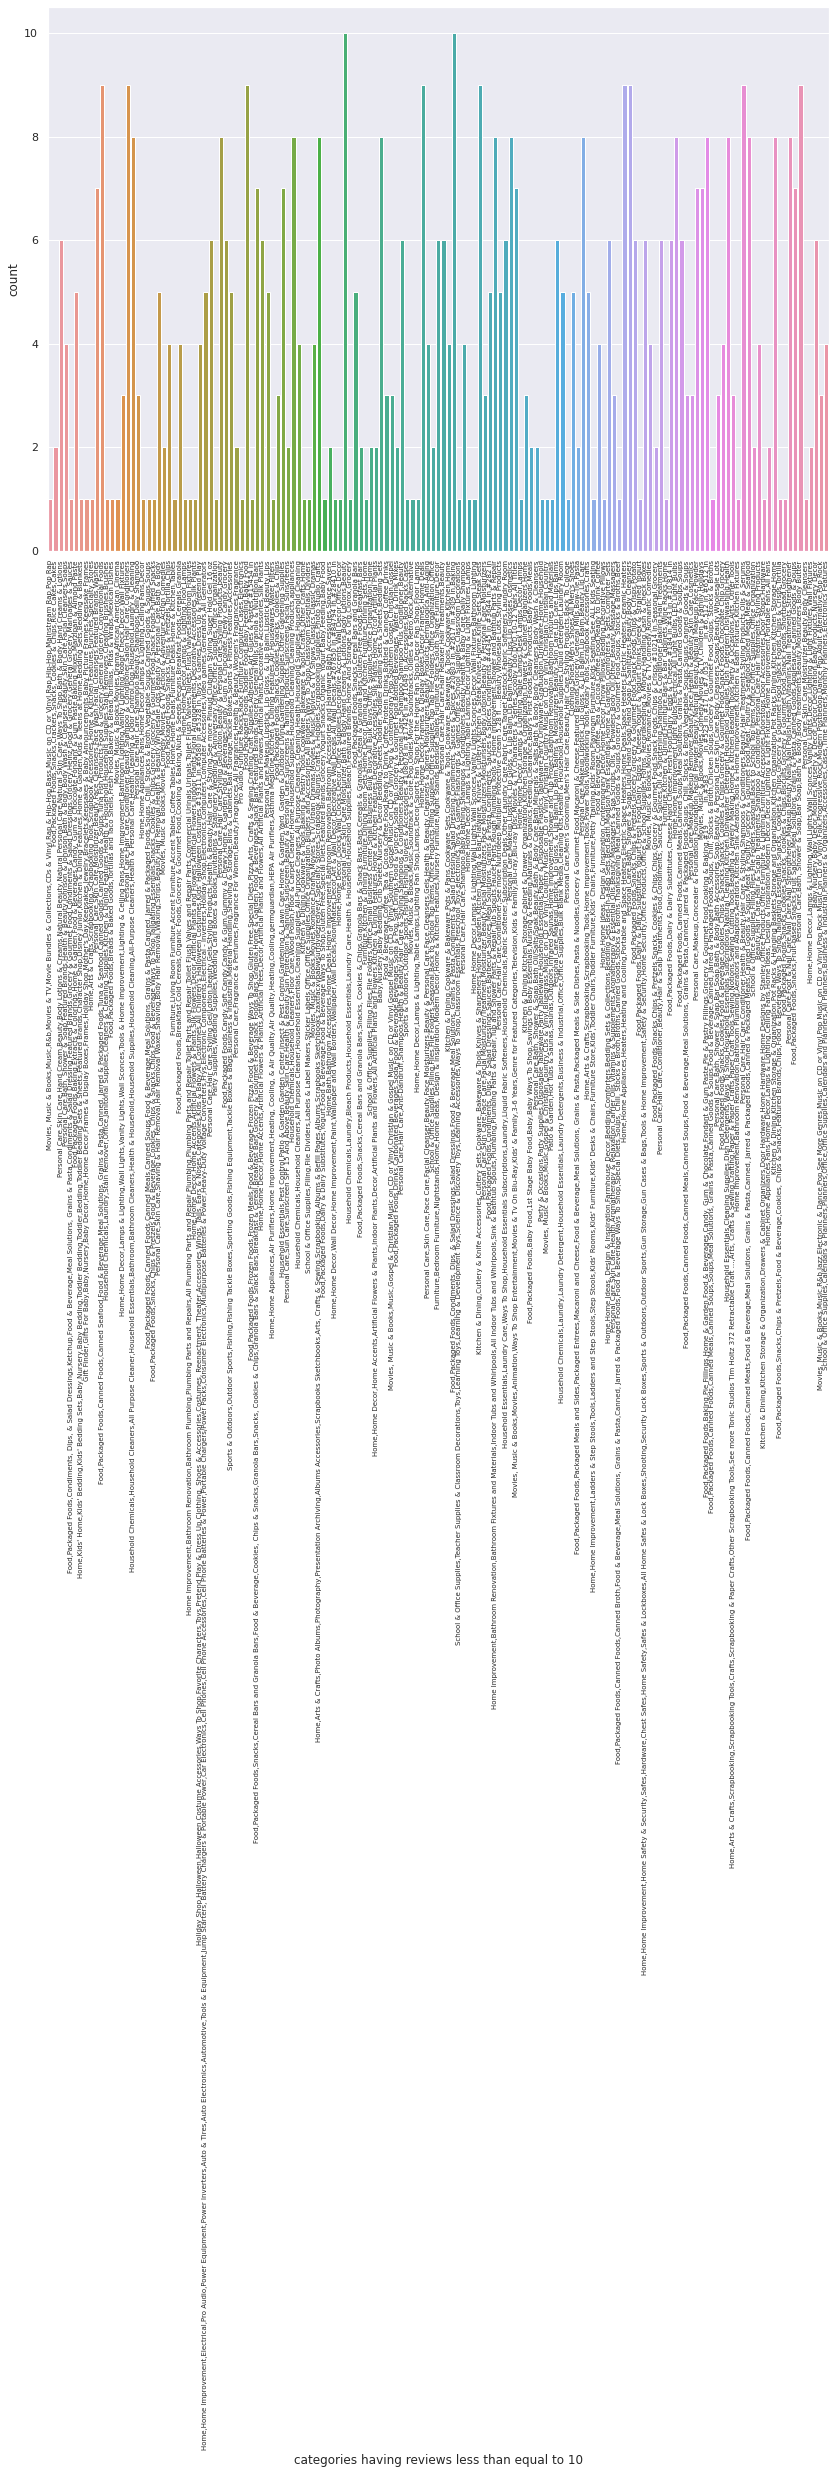

In [203]:
#for categories having reviews less than equal to 10 reviews
plot_graph(df,'categories',0)

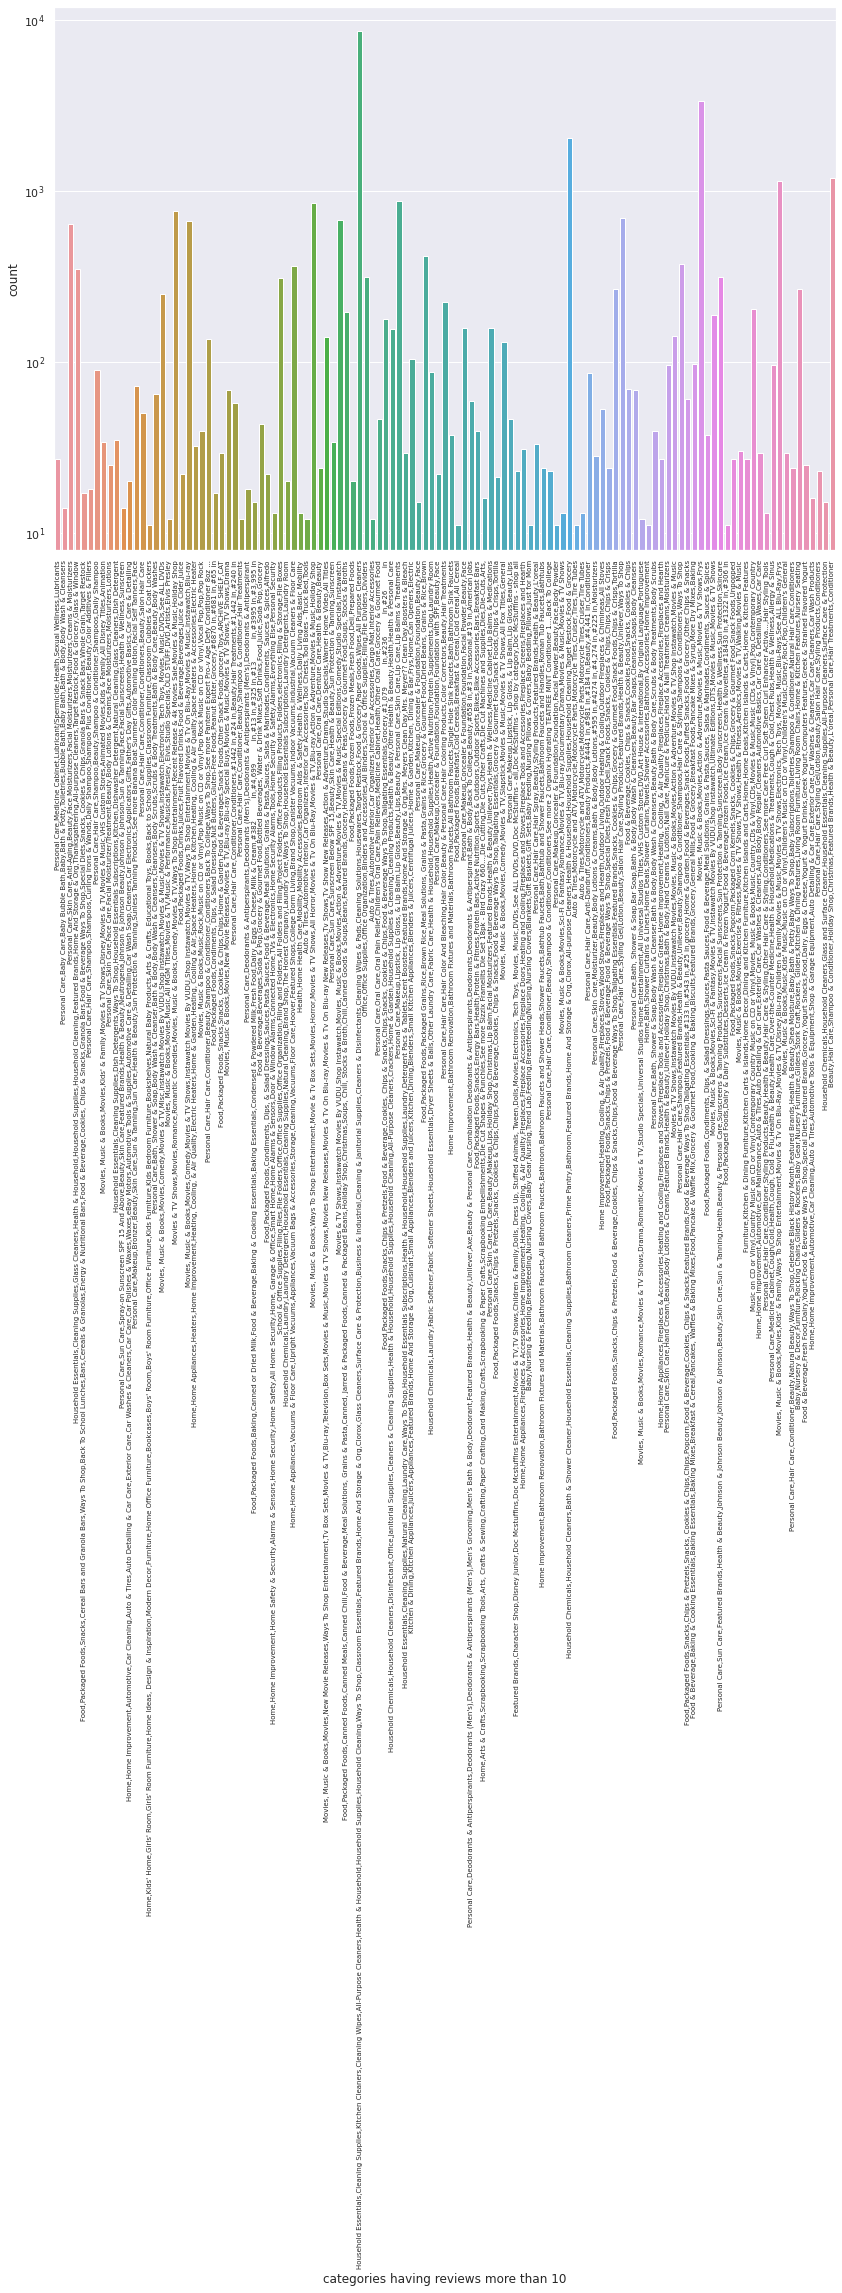

In [204]:
#for categories having reviews more than 10 reviews
plot_graph(df,'categories',1)

In [205]:
# we will take the top 50 products for our analysis
df['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
5302050 15/16 FCT/HOSE ADAPTOR                                                       1
Clorox Ultimate Care Premium Bleach                                                  1
Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174                    1
Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct                                       1
Pink Friday: Roman Reloaded Re-Up (w/dvd)                                            1
Name: name, Length: 271, dtype: int64

In [206]:
#no of unique products present in dataset
len(df['name'].unique())

271

In [207]:
#creating a temp data frame for top 50 products
df_top50 = df.loc[df['name'].isin(list(df['name'].value_counts()[0:49].index))]

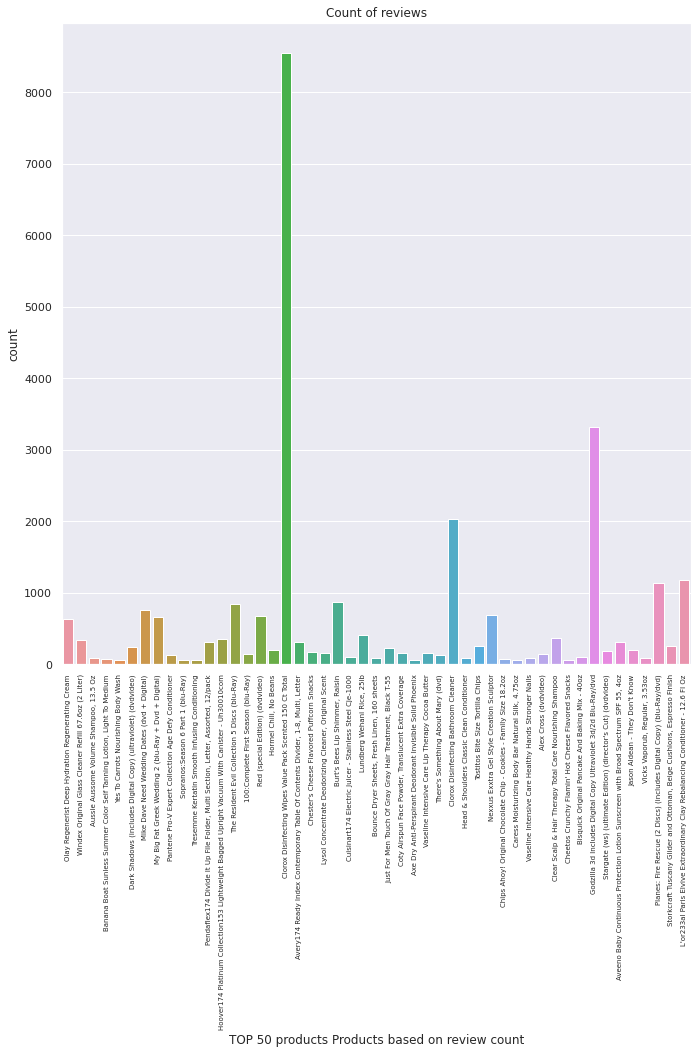

In [208]:
#plot for the top 50 prod
top50_dims = (14, 10)
fig, fx = plt.subplots(figsize=top50_dims)
cx = sns.countplot(x = 'name', data = df_top50)
plt.xlabel('TOP 50 products Products based on review count')
plt.title('Count of reviews')
plt.tight_layout()
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()

From the above plot it is evident how imbalance the data is in the data set which needs to be treated before proceeding for modelling

In [209]:
df['reviews_didPurchase'].value_counts()

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64

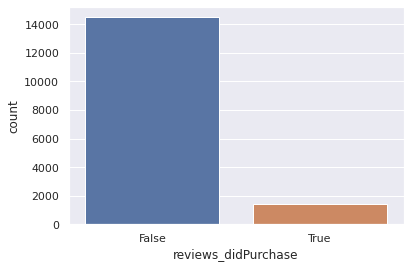

In [210]:
sns.countplot(x = 'reviews_didPurchase' , data = df)
plt.show()

Here as well we can see the imbalance in the class, for the missing values even if we assume they did not buy the product leaves us with almost 46% missing value

In [211]:
# we will take the top 100 title for our analysis
df['reviews_title'].value_counts()

Great Product                       384
Great movie                         361
Clorox Wipes                        278
Great                               221
Great product                       205
                                   ... 
Keeping them healthy!                 1
Fighting Power                        1
great all together                    1
Great Product and Easy to Use...      1
Conditioned into healthy              1
Name: reviews_title, Length: 18535, dtype: int64

In [212]:
#no of unique products present in dataset
len(df['reviews_title'].unique())

18536

In [213]:
#creating a temp data frame for top 100 titles
df_top50_t = df.loc[df['reviews_title'].isin(list(df['reviews_title'].value_counts()[0:99].index))]

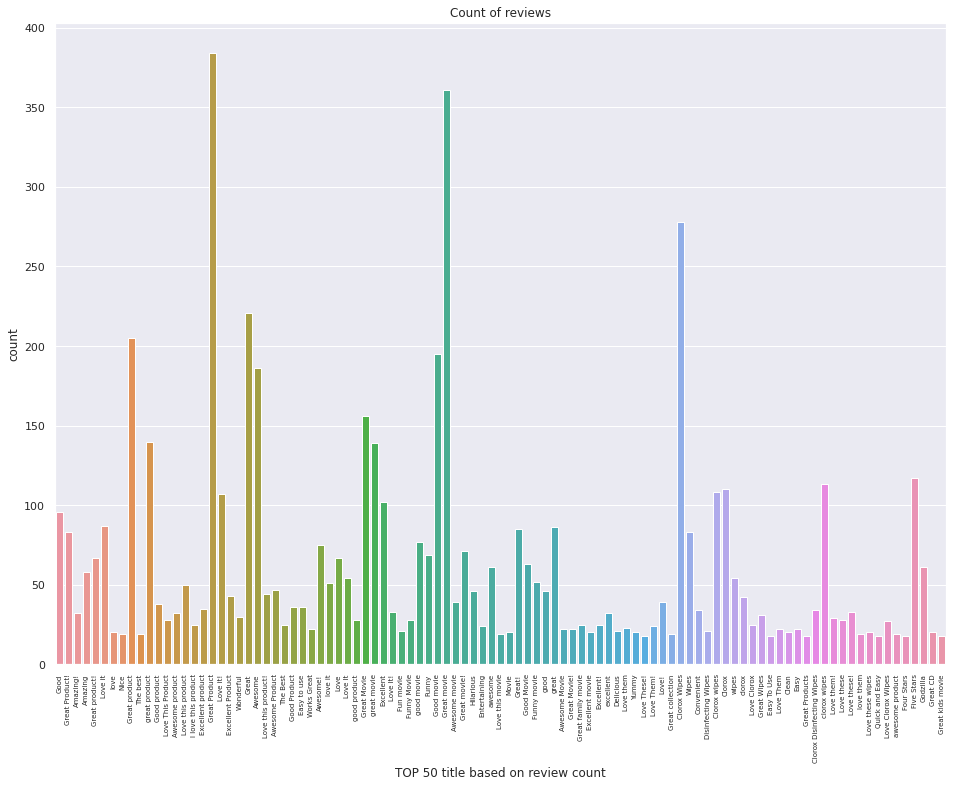

In [214]:
#plot for the top 50 prod
top50_dims = (14, 10)
fig, fx = plt.subplots(figsize=top50_dims)
cx = sns.countplot(x = 'reviews_title', data = df_top50_t)
plt.xlabel('TOP 50 title based on review count')
plt.title('Count of reviews')
plt.tight_layout()
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()

Browsing through it seems mostly are having a positive review

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Bivariate Analysis

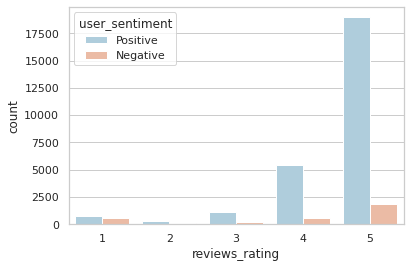

In [216]:
#checking the effect of reviews_rating column on target column user_sentiment
sns.set_style('whitegrid')
sns.countplot(x = 'reviews_rating', hue = 'user_sentiment', data = df, palette='RdBu_r')
plt.show()

As seen in the above visualization the data is highly imbalance, an important observation is that people are still not having a positive sentiment even when 5 rating has been given. This difference in ratio  is larger when compared to 4 star rating category

# Data pre-processing for user_sentiment column
##### we can see that it has only a single null entry which we can manually set as +ve or -ve by checking the review text against it

In [217]:
#Setting max column display to read complete review
pd.set_option('display.max_colwidth',None)

In [218]:
#checking the text of the review present
df['reviews_text'][df['user_sentiment'].isnull()]

28354    my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy
Name: reviews_text, dtype: object

In [219]:
#checking the rating given by the user
df['reviews_rating'][df['user_sentiment'].isnull()]

28354    5
Name: reviews_rating, dtype: int64

#### As evident from the above review text and the review rating we can safely assume that this is a positive sentiment

In [220]:
#making the missing value as Positive sentiment
df['user_sentiment'].fillna('Positive', inplace = True)

In [221]:
df['user_sentiment'].value_counts()

Positive    26633
Negative     3367
Name: user_sentiment, dtype: int64

In [222]:
#We are changing the sentiments in form of 1 for positive and 0 for negative
df['user_sentiment'] = df['user_sentiment'].apply(lambda x : 1 if x == 'Positive' else 0)

In [223]:
df['user_sentiment'].value_counts()

1    26633
0     3367
Name: user_sentiment, dtype: int64

In [224]:
#checking for brands having most positive rating.
df_brand = df.pivot_table(index = 'brand', columns = 'reviews_rating', values = 'user_sentiment', aggfunc=np.sum, margins= True)

In [225]:
df_brand

reviews_rating,1,2,3,4,5,All
brand,,,,,,
4C Foods,NaN,NaN,NaN,NaN,5.0,5
AMBI,NaN,NaN,NaN,1.0,3.0,4
ANCHOR BAY,NaN,NaN,1.0,5.0,23.0,29
Africa's Best,0.0,NaN,NaN,1.0,4.0,5
Alberto VO5,NaN,NaN,NaN,NaN,2.0,2
...,...,...,...,...,...,...
Yes to Carrots,2.0,2.0,2.0,4.0,55.0,65
Yes to Grapefruit,1.0,1.0,4.0,9.0,17.0,32
Yosemite Home Decor,0.0,NaN,NaN,NaN,NaN,0


In [226]:
def plot_graph2(df,rating,ax):
     df_temp = df[rating].nlargest(n=11).to_frame()
     df_temp.reset_index(inplace = True)
     sns.barplot(x = 'brand',y = rating, data = df_temp, log = True,ax = ax)
     a = str(rating)
     plt.ylabel('total number of +ve sentiments')
     plt.title('top 10 brands in rating category '+a)
     plt.xticks(rotation=90)

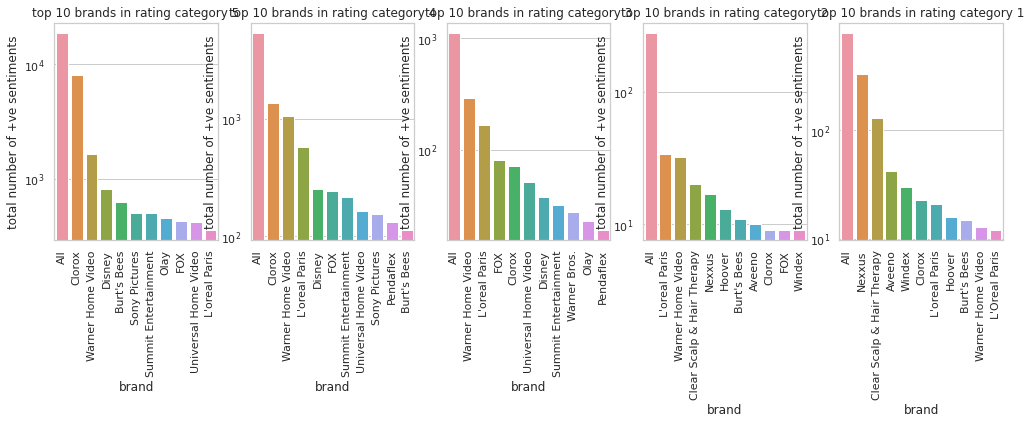

In [227]:
plt.figure(figsize=(17,4))
ax1 = plt.subplot(1,5,1)
plot_graph2(df_brand,5,ax1)
ax2 = plt.subplot(1,5,2)
plot_graph2(df_brand,4,ax2)
ax3 = plt.subplot(1,5,3)
plot_graph2(df_brand,3,ax3)
ax4 = plt.subplot(1,5,4)
plot_graph2(df_brand,2,ax4)
ax5 = plt.subplot(1,5,5)
plot_graph2(df_brand,1,ax5)

Thus as we can see in the above graph that how the rating 4 and 5 are dominated by a single brand and later the leader brand gets changed as rating drop to 3 and below

# Data cleaning and pre-processing

We had observed in one of the bivariate analysis that the sentiment for a few reviews were given as negative even though the rating was 4 or 5, we will check few of these and if found a data error will fix the same

In [228]:
df[(df["user_sentiment"]==0) & (df["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
29818,Great Product,"I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as part of a promotion.",5
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.,5
29858,Makes my hair soft and shiny without excess oil!,"This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a promotion.",5
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a promotion.,5


As we can see in the above records, we can assign the positive user_sentiment, i.e. 1 to the user_sentiment column for the reviews having rating greater than equal to 4

Checking the same clause for the reviews having positive rating for products having less than 4 rating

In [229]:
df[(df["user_sentiment"]==1) & (df["reviews_rating"]<=3)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
...,...,...,...
29050,Didn't Do Much For Dryness,"I received this product from Influenster. I absolutely love the whole system together, it made my hair oil-free for 48 hours. But I expected the conditioner to do more for the dryness at the ends of my hair like advertised. I didn't really notice much of a different in dryness before and after I used it. But overall, I still would probably purchase the system again because of how amazing it worked to get rid of my oily roots. *I received this product compliments of Influenster, but all opinions are my own. This review was collected as part of a promotion.",3
29051,Not the best,"I used this product for a month straight before reviewing it and I'm not really all that impressed. My hair still gets pretty oily, my ends are still dry.... I mean it cleaned my hair I guess. It's nothing spectacular really. It didn't make my hair extremely soft but it didn't make my hair feel weird or heavy either. This review was collected as part of a promotion.",3
29053,clay conditioning,Got this item as a compliment from influenster but it really made my hair smooth and shining after the usage. This review was collected as part of a promotion.,3
29054,Eh,"I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel like this did anything for my ends. I would buy the other two, but not this, probably because I have fine hair and my ends need deep conditioning. Smells great though! I got this product free for testing and review purposes but the opinions are entirely my own. ExtraordinaryClay, LorealHair contest, ad, spon, sweepstakes influenster This review was collected as part of a promotion.",3


As evident from the majority of the records obtained, we can put 0 (negative) as user_sentiment for the reviews having rating less than equal to 3

In [230]:
#creating a subset df to make all the cleaning and data adjustment and modelling
df_correction = df[['id','name','reviews_rating','reviews_text','reviews_title','user_sentiment']]

In [231]:
#creating a crosstab to check the total count for each rating category
pd.crosstab(df_correction["user_sentiment"], df_correction["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18971,26633
All,1384,420,1345,6020,20831,30000


Thus as discussed in the above cell it seems that there is some ambiguity in the data which we can fix using the rule such as reviews having less than 4 rating will be set as -ve sentiment and reviews having rating as 4 or 5 will be set as +ve sentiment

In [232]:
#Giving a -ve sentiment to reviews having rating as 1,2 or 3
df_correction.loc[(df_correction["user_sentiment"]==1) & (df_correction["reviews_rating"]<4), "user_sentiment"] = 0

In [233]:
#Giving a +ve sentiment to reviews having rating as 4 or 5
df_correction.loc[(df_correction["user_sentiment"]==0) & (df_correction["reviews_rating"]>3), "user_sentiment"] = 1

In [234]:
#Checking for the changes
pd.crosstab(df_correction["user_sentiment"], df_correction["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20831,26851
All,1384,420,1345,6020,20831,30000


In [235]:
df_correction.user_sentiment.value_counts()

1    26851
0     3149
Name: user_sentiment, dtype: int64

As we can see in the above cell the data is highly imbalanced which needs to be taken care of

In [236]:
df_correction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              30000 non-null  object
 1   name            30000 non-null  object
 2   reviews_rating  30000 non-null  int64 
 3   reviews_text    30000 non-null  object
 4   reviews_title   29810 non-null  object
 5   user_sentiment  30000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In the current dataframe we have 2 text fields i.e. reviews_text and reviews_title we can use both of these in the text processing, perform text cleaning operations such as stopword removal , lematization , etc

In [237]:
#filling the missing data in title column with blank
df_correction["reviews_title"] = df_correction["reviews_title"].fillna('')

In [238]:
#concating the title and text in one single column removing all preceeding spaces
df_correction["reviews_combine"] = df_correction[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [239]:
df_correction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               30000 non-null  object
 1   name             30000 non-null  object
 2   reviews_rating   30000 non-null  int64 
 3   reviews_text     30000 non-null  object
 4   reviews_title    30000 non-null  object
 5   user_sentiment   30000 non-null  int64 
 6   reviews_combine  30000 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.6+ MB


In [240]:
df_correction.head()

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,1,Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,1,Good. Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,1,Good. Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,0,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,0,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [241]:
df_correction[df_correction['reviews_combine'].str.contains('\[\s*\w*\s*\]')]

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
1924,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4,Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.,Mike and Dave Need Wedding Dates,1,Mike and Dave Need Wedding Dates. Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.
6075,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,"Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",RED will not disappoint - its a great view.,1,"RED will not disappoint - its a great view.. Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside."
6247,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,"Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed ??it was routine. The show is most likely one of the best spy ??counter spy flicks that I have seen. With a superb blend of ??enior??casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",RED will not disappoint - its a great view.,1,"RED will not disappoint - its a great view.. Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed ??it was routine. The show is most likely one of the best spy ??counter spy flicks that I have seen. With a superb blend of ??enior??casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside."
23567,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,"Godzilla [Blu-ray] [2014] is a super reboot of every bodies favorite monster. He first appeared in 1954 and has been going strong ever since. And I got a coupon to see ""Kong - Skull Island"" which was awesome. Love value added.",A Great Reboot,1,"A Great Reboot. Godzilla [Blu-ray] [2014] is a super reboot of every bodies favorite monster. He first appeared in 1954 and has been going strong ever since. And I got a coupon to see ""Kong - Skull Island"" which was awesome. Love value added."


It seems like there are few words embedded in [] pair of bracket which can be removed from the dataset

In [242]:
#we will proceed to create a function to clean this new feature created
def clean_text(text_feature):
    text_feature = text_feature.lower() #making all text to lower
    text_feature = text_feature.strip() #removing spaces from start and end
    text_feature = re.sub("\[\s*\w*\s*\]", "", text_feature) # removing the text b/w []
    text_feature = re.sub(r'[^\w\s]', '', text_feature) # removing punctutions
    text_feature = re.sub("\S*\d\S*", "", text_feature) #removing digits
    return text_feature

In [243]:
df_correction['reviews_combine'] = df_correction['reviews_combine'].apply(lambda x : clean_text(x))

In [244]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it  rating all the way her metaphors are just crazy
1                                                                                                                                                                                                                                                                                                                    

The text looks clean now we will proceed to remove the stop words from the corpus

In [245]:
stop_words = set(stopwords.words("english"))

in the stop words list we can see a few words which are important for pointing out a negative review, words such as not, never , no, thus we will remove these words from the stop words list and they will be present in the corpus

In [246]:
ele_to_remove = ['no','not','never']
stop_words = stop_words - set(ele_to_remove)

In [247]:
if ('no' in stop_words) & ('not' in stop_words) & ('never' in stop_words):
    print('elements present')
else :
    print('elements successfully deleted')

elements successfully deleted


In [248]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'sam

In [249]:
from collections import Counter

In [250]:
# Remove stopwords function
def remove_stopwords(text,stop_words):
    words = text.split()
    stopwords_dict = Counter(stop_words)
    text = " ".join([word for word in words if word not in stopwords_dict])
    return text

In [251]:
df_correction['reviews_combine'] = df_correction['reviews_combine'].apply(lambda x : remove_stopwords(x,stop_words))

In [252]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                                         awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphors crazy
1                                                                                                                                                                                                                                                                                                                                                                                                        good good flavor review collected part promotion
2                                                                                                                   

#### Now once stop words have been removed we will be using lematization to reduce the words to their base form

In [253]:
# Using a helper function to get better lemetized result
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [254]:
#Lemmatize function
lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(text)) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

In [255]:
df_correction["reviews_combine"] = df_correction['reviews_combine'].apply(lambda x: lemma_text(x))

In [256]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                 awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1                                                                                                                                                                                                                                                                                                                                                                                 good good flavor review collect part promotion
2                                                                                                                                                                     

In [257]:
df_correction.head()

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,1,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,1,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,0,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,0,irritation husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel


In [258]:
#seperating the dependent and independent features
X = df_correction['reviews_combine']
y = df_correction['user_sentiment']

In [259]:
y.value_counts()

1    26851
0     3149
Name: user_sentiment, dtype: int64

We can see that there is high imbalance in the data as +ve review is much more, thus we will use smote to overcome this

In [260]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_correction['reviews_combine'])

In [261]:
#getting feature names
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'action movie'
 'actor' 'actually' 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'available' 'away' 'awesome' 'awesome movie' 'awesome product'
 'awful' 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful'
 'bee' 'begin' 'believe' 'best' 'best buy' 'best product' 'big' 'bit'
 'black' 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'box' 'boy'
 'brand' 'break' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt'
 'burt bee' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'character' 'cheap' 'child' 'chip' 'classic' 'classroom'
 'clay' 'clean' 'clean bathroom' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean kitchen' 'clean love' 'clean mess'
 'clean product' 'clean review' 'clean smell' 'clean ups' 'clean use'
 'clean wipe' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox love' 'clorox product' 'clorox wipe' 'close'
 'cocoa' 'cold' 'collect' '

In [262]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=92, test_size=0.25)

In [263]:
#SMOTE implementation
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 20095, 0: 2405})
After Counter({1: 20095, 0: 20095})


# Model building

In [264]:
#importing necessary files for model building
import time
from sklearn import metrics
import pickle

In [265]:
#Utility function to display accuracy
def display_score(classifier):
    dm = confusion_matrix(y_test, classifier.predict(X_test))
    dis = ConfusionMatrixDisplay(confusion_matrix=dm, display_labels=classifier.classes_)
    dis.plot() 
    print(classifier)
    print('\n')
    print('Accuracy of the model is ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity of the model is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity of the model is {}'.format(cm[0][0]/sum(cm[0])))

## Logistic Regression

### Using a class based approach for evaluating the models

In [266]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("*"*30)
        print("\n")
        
        metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="PiYG", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

In [267]:
#importing logisting regression
from sklearn.linear_model import LogisticRegression

In [268]:
# Building a Logistic Regression model.
%time
logreg_ci = LogisticRegression(random_state=92, max_iter=150,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs




******************************
Accuracy is : 88.0%
Precision is : 97.0%
Recall is : 89.4%
F1 Score is : 93.0%
Roc-Auc Score is:90.5%
******************************


              precision    recall  f1-score   support

           0       0.44      0.74      0.55       744
           1       0.97      0.89      0.93      6756

    accuracy                           0.88      7500
   macro avg       0.70      0.82      0.74      7500
weighted avg       0.92      0.88      0.89      7500

******************************




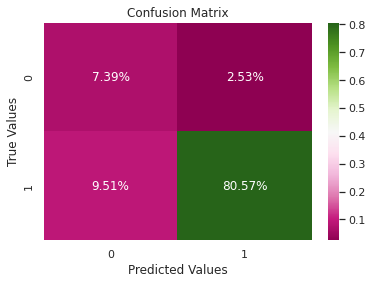

******************************




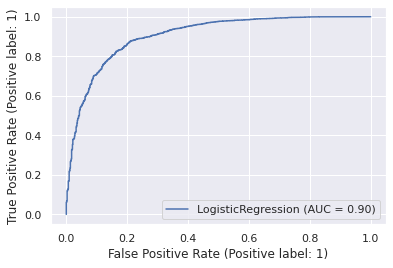

In [269]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

Even if the F1 score looks good lets explore the other algorithms

In [270]:
# Using the multinomial naive bayes character
from sklearn.naive_bayes import MultinomialNB

In [271]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 81.6%
Precision is : 97.8%
Recall is : 81.4%
F1 Score is : 88.8%
Roc-Auc Score is:90.2%
******************************


              precision    recall  f1-score   support

           0       0.33      0.83      0.47       744
           1       0.98      0.81      0.89      6756

    accuracy                           0.82      7500
   macro avg       0.65      0.82      0.68      7500
weighted avg       0.91      0.82      0.85      7500

******************************




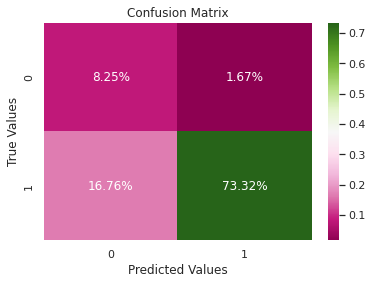

******************************




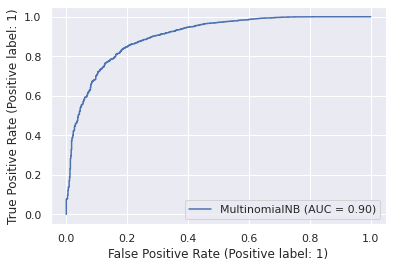

In [272]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

##### Decision Tree

In [273]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [274]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [275]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 84.1%
Precision is : 95.7%
Recall is : 86.2%
F1 Score is : 90.7%
Roc-Auc Score is:83.9%
******************************


              precision    recall  f1-score   support

           0       0.34      0.65      0.45       744
           1       0.96      0.86      0.91      6756

    accuracy                           0.84      7500
   macro avg       0.65      0.76      0.68      7500
weighted avg       0.90      0.84      0.86      7500

******************************




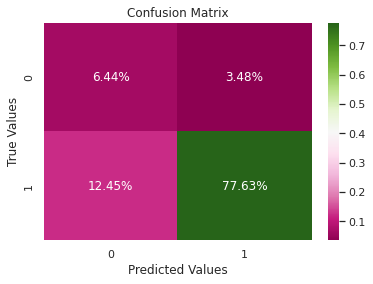

******************************




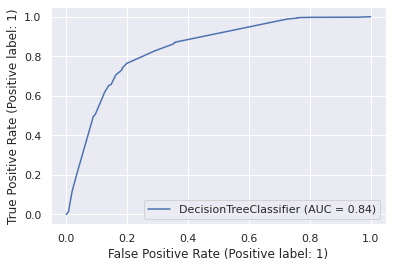

In [276]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

##### Random Forest

In [277]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [278]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [279]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [280]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [281]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 81.4%
Precision is : 96.0%
Recall is : 82.7%
F1 Score is : 88.9%
Roc-Auc Score is:85.8%
******************************


              precision    recall  f1-score   support

           0       0.31      0.69      0.42       744
           1       0.96      0.83      0.89      6756

    accuracy                           0.81      7500
   macro avg       0.63      0.76      0.66      7500
weighted avg       0.90      0.81      0.84      7500

******************************




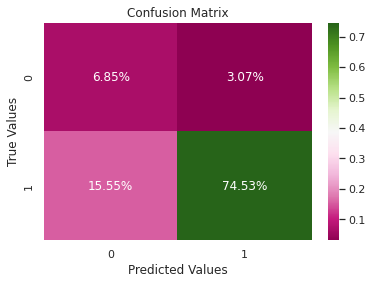

******************************




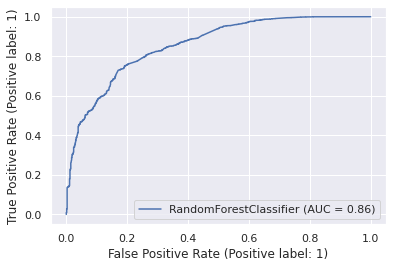

In [282]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

##### XG BOOST

In [283]:
import xgboost as xgb

In [284]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 91.0%
Precision is : 96.3%
Recall is : 93.6%
F1 Score is : 94.9%
Roc-Auc Score is:91.1%
******************************


              precision    recall  f1-score   support

           0       0.54      0.67      0.60       744
           1       0.96      0.94      0.95      6756

    accuracy                           0.91      7500
   macro avg       0.75      0.80      0.77      7500
weighted avg       0.92      0.91      0.91      7500

******************************




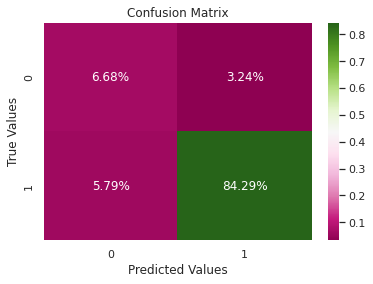

******************************




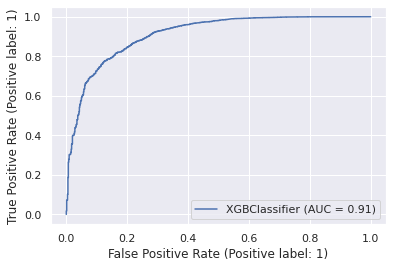

In [285]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [286]:
# Creating a dataframe which contains all the metrics from all models

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.879600,0.815733,0.840667,0.813867,0.909733
1,Precision,0.969517,0.977774,0.957094,0.960481,0.962986
2,Recall,0.894464,0.813943,0.861753,0.827413,0.935761
3,F1Score,0.930480,0.888368,0.906924,0.888995,0.949178
4,Auc Score,0.904561,0.901870,0.838882,0.857538,0.910849


Comparing all the models we see that XG Boost is better than the rest of the models but due to hereko's limitation need to use a seperate model, thus going with Logistic regression

In [287]:
def save_object(obj, filename):
    filename = "pickle\\"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [288]:
save_object(logreg_ci, 'sentiment-classification-logistic-regression-model')

In [289]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [290]:
save_object(df_correction, 'cleaned-data')

# ------------------------------END of Modelling-------------------------------------

# Recommendation System

### We are gonna try both the approaches of collaborative filtering techniques:

1. User-User based approach
2. Item-Item based approach

In [291]:
#using the orginal dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        30000 non-null  int64 
dtypes: int64(2), object(13)
memory usage

In [292]:
df_recommendation = df[["id", "name", "reviews_rating", "reviews_username"]]

In [293]:
df_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   name              30000 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_username  29937 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


Since there are few null values in username column we will only use the records which have username present

In [294]:
df_recommendation = df_recommendation[~df_recommendation['reviews_username'].isna()]

In [295]:
df_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29937 non-null  object
 1   name              29937 non-null  object
 2   reviews_rating    29937 non-null  int64 
 3   reviews_username  29937 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [296]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=92)

In [297]:
#checking the size of the splits
print(train.shape)
print(test.shape)

(22452, 4)
(7485, 4)


In [298]:
df_recommendation['id'].value_counts()

AVpf3VOfilAPnD_xjpun    8525
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfP-rELJeJML435jEN       1
AVpfbpzd1cnluZ0-kqJV       1
AVpfbjraLJeJML439F91       1
AVpfa1joLJeJML4385hb       1
AV13O1A8GV-KLJ3akUyj       1
Name: id, Length: 271, dtype: int64

#### Note: Here we see that values in id columns are repeated denoting that this are not review ids but rather are the product ids.

In [299]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index='reviews_username', columns = 'id', values = 'reviews_rating' ).fillna(0)
df_pivot.head(10)

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.11E+24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [300]:
#Creating a dummy train and test
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [301]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
8473,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,lindsey11
24476,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,hulk
19416,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,cldeal72
22022,AVpfnRuSilAPnD_xfB8l,Yes To Grapefruit Rejuvenating Body Wash,1,mircea r
20842,AVpfLnfPLJeJML434HpK,"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201",5,woodsntrails


In [302]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [303]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index='reviews_username', columns = 'id', values = 'reviews_rating').fillna(1)
dummy_train.head(10)

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.11E+24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1085,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [304]:
df_pivot.index.nunique()

19377

In [305]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [306]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(19377, 19377)


Prediction for User-User

In [307]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [308]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  1.80893651, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  9.91222613, ...,  0.        ,
         0.        ,  0.57353933],
       [ 0.        ,  5.57904322, 19.42720697, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , 12.37166772, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  9.91222613, ...,  0.        ,
         0.        ,  0.57353933],
       [ 0.        ,  0.        , 12.37166772, ...,  0.        ,
         0.        ,  0.        ]])

In [309]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,1.808937,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,6.028123,0.0,0.0,0.0,0.0,4.091114,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.000000
00sab00,0.0,0.000000,9.912226,0.0,0.0,0.521286,0.000000,2.886751,0.0,0.0,0.000000,0.0,0.0,3.166573,0.930505,0.000000,0.000000,0.0,0.0,0.0,2.085144,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,18.644275,0.0,0.0,0.0,75.639095,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.12132,0.000000,0.0,0.0,0.0,4.074241,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,4.924147,6.578235,0.000000,1.771873,0.0,0.0,2.561578,1.940376,0.000000,2.500000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.573539
01impala,0.0,5.579043,19.427207,0.0,0.0,0.000000,2.275520,0.000000,0.0,0.0,1.982629,0.0,0.0,3.642164,1.406096,3.535534,0.000000,0.0,0.0,0.0,0.000000,3.535534,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,27.170635,0.0,0.0,0.0,128.472369,0.0,0.0,0.0,0.0,83.485691,0.0,...,0.0,0.0,0.0,0.0,0.0,1.323807,0.0,0.0,0.0,0.00000,2.886751,0.0,0.0,0.0,8.430541,0.0,0.0,0.0,2.950508,0.0,0.0,0.70014,5.010883,7.850487,4.278637,2.487593,0.0,0.0,6.305420,3.442608,0.267261,0.000000,1.555428,1.478431,0.0,0.00000,2.94902,0.0,0.0,0.000000
02deuce,0.0,5.579043,19.427207,0.0,0.0,0.000000,2.275520,0.000000,0.0,0.0,1.982629,0.0,0.0,3.642164,1.406096,3.535534,0.000000,0.0,0.0,0.0,0.000000,3.535534,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,27.170635,0.0,0.0,0.0,128.472369,0.0,0.0,0.0,0.0,83.485691,0.0,...,0.0,0.0,0.0,0.0,0.0,1.323807,0.0,0.0,0.0,0.00000,2.886751,0.0,0.0,0.0,8.430541,0.0,0.0,0.0,2.950508,0.0,0.0,0.70014,5.010883,7.850487,4.278637,2.487593,0.0,0.0,6.305420,3.442608,0.267261,0.000000,1.555428,1.478431,0.0,0.00000,2.94902,0.0,0.0,0.000000
06stidriver,0.0,0.000000,12.371668,0.0,0.0,6.659009,3.402069,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.680721,0.000000,0.680414,0.0,0.0,0.0,0.000000,9.159009,0.0,0.0,0.

Find top 20 recommendation for user

In [310]:
user_input = '00sab00' 
print(user_input)

00sab00


In [311]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

id
AVpfPaoqLJeJML435Xk9    83.485691
AVpe41TqilAPnD_xQH3d    75.639095
AVpfRTh1ilAPnD_xYic2    59.182971
AVpf0eb2LJeJML43EVSt    30.961167
AVpf2tw1ilAPnD_xjflC    21.237123
AVpfM_ytilAPnD_xXIJb    19.097256
AVpfJP1C1cnluZ0-e3Xy    18.927225
AVpe31o71cnluZ0-YrSD    18.644275
AVpf3VOfilAPnD_xjpun    16.346580
AVpf63aJLJeJML43F__Q    14.042534
AVpfR5m0LJeJML436K3W    12.735650
AVpf5olc1cnluZ0-tPrO    12.003205
AVpf5Z1zLJeJML43FpB-    11.568034
AV1YGDqsGV-KLJ3adc-O     9.912226
AVpfPnrU1cnluZ0-g9rL     9.065941
AVpfazX31cnluZ0-kbdl     8.229631
AVpf385g1cnluZ0-s0_t     7.820645
AVpe8gsILJeJML43y6Ed     6.890523
AVpfov9TLJeJML43A7B0     6.578235
AVpfOmKwLJeJML435GM7     6.138281
Name: 00sab00, dtype: float64

In [312]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,83.485691
2526,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),75.639095
3099,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),59.182971
3962,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),30.961167
4593,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),21.237123
5076,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,19.097256
5282,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,18.927225
6791,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),18.644275
6981,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,16.346580
13361,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",14.042534


Evaluation for User-User

In [313]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1718, 4)

In [314]:
common.head()

,id,name,reviews_rating,reviews_username
13982,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,flyswimmer56
18034,AVpfcu821cnluZ0-k8ep,Vaseline Intensive Care Lip Therapy Cocoa Butter,5,chellington
11319,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,mimi671
17983,AVpfcu821cnluZ0-k8ep,Vaseline Intensive Care Lip Therapy Cocoa Butter,5,james
19838,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,vikki


In [315]:
# convert into the user-item matrix.
common_user_based_matrix = pd.pivot_table(common,index='reviews_username', columns = 'id', values = 'reviews_rating')
common_user_based_matrix.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,...,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 rooms 1 dog lotsa fur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.514496,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.707107,1.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.514496,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.707107,1.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.529813,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [317]:
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.514496,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.707107,1.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.514496,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.707107,1.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.529813,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [318]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [319]:
user_correlation_df_1.shape

(1495, 19377)

In [320]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [321]:
user_correlation_df_3 = user_correlation_df_2.T

In [322]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.34487885, ..., 0.        , 2.64906471,
        0.37463432],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.56568542],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [323]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index='reviews_username', columns = 'id', values = 'reviews_rating').fillna(0)

In [324]:
dummy_test.shape

(1495, 125)

In [325]:
common_user_based_matrix.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,...,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 rooms 1 dog lotsa fur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [326]:
dummy_test.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,...,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [327]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [328]:
common_user_predicted_ratings.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,...,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.893107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.569443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.064407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [330]:
common_ = pd.pivot_table(common,index='reviews_username', columns = 'id', values = 'reviews_rating')

In [331]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [332]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.0643692983086126


Item based recommendation system

In [333]:
df_pivot = pd.pivot_table(train,
    index='id',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02deuce,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12gage,132457,13ld,13thfaerie,1421nikki,143st,148maine,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,...,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoomin76,zoso60,zotox,zout22389,zpalma,zsazsa,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [335]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02deuce,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12gage,132457,13ld,13thfaerie,1421nikki,143st,148maine,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,...,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoomin76,zoso60,zotox,zout22389,zpalma,zsazsa,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.126437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [336]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [337]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Prediction for Item-Item

In [338]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.01688773, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01234405, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Filtering the rating only for the products not rated by the user for recommendation

In [339]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.016888,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.032298,0.0,0.0,0.0,0.0,0.026644,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00645,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012809,0.0,0.0,0.0,0.083572,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.022017,0.000000,0.0,0.000000,0.0,0.0,0.01424,0.003147,0.000000,0.007532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.012344,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.003201,0.0,0.0,0.006282,0.001263,0.043079,0.0,0.0,0.0,0.0,0.0,0.00099,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.015669,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000019,0.0,0.0,0.0,0.011691,0.0,0.0,0.0,0.000000,0.002944,0.0,0.003812,0.0,0.0,0.00000,0.000845,0.076277,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.016459,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.004268,0.0,0.0,0.008375,0.001683,0.057438,0.0,0.0,0.0,0.0,0.0,0.00132,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020892,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000025,0.0,0.0,0.0,0.015588,0.0,0.0,0.0,0.000000,0.003926,0.0,0.005082,0.0,0.0,0.00000,0.001127,0.101703,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.000000,0.000000,0.0,0.0,0.001714,0.001899,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.007654,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003059,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00426,0.005196,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001178,0.001070,0.0,0.002032,0.0,0.0,0.00000,0.000000,0.000000,0.002308,0.0

Finding the top 20 recommendation for the user

In [340]:
# Take the user ID as input
user_input = '00sab00'
print(user_input)

00sab00


In [341]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

id
AVpfE7puilAPnD_xUcCW    0.191373
AVpe41TqilAPnD_xQH3d    0.083572
AVpe_dxlilAPnD_xSiHI    0.053055
AVpf5ujMilAPnD_xkQVi    0.041075
AVpf0thK1cnluZ0-r8vR    0.040469
AVpf7aUAilAPnD_xkqbP    0.038698
AVpe7sl91cnluZ0-aI1Y    0.038068
AVpfOIrkilAPnD_xXgDG    0.032224
AVpe_pDG1cnluZ0-bjSf    0.023126
AVpfoSS51cnluZ0-oVH9    0.022017
AVpfOmKwLJeJML435GM7    0.020061
AVpe6FfKilAPnD_xQmHi    0.019983
AVpfR5m0LJeJML436K3W    0.019390
AVpfHf4wLJeJML432vqK    0.016765
AVpfr5cb1cnluZ0-pZFp    0.014240
AVpe31o71cnluZ0-YrSD    0.012809
AVpfLnfPLJeJML434HpK    0.011291
AVpf0eb2LJeJML43EVSt    0.010948
AVpf5olc1cnluZ0-tPrO    0.010760
AVpfRTh1ilAPnD_xYic2    0.010378
Name: 00sab00, dtype: float64

In [342]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.191373
6,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),0.083572
579,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",0.053055
586,AVpf5ujMilAPnD_xkQVi,D-Con Mice Bait Station - 3ct,0.041075
592,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.040469
687,AVpf7aUAilAPnD_xkqbP,SC Johnson One Step No Buff Wax,0.038698
692,AVpe7sl91cnluZ0-aI1Y,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,0.038068
724,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.032224
836,AVpe_pDG1cnluZ0-bjSf,Bi-O-kleen Spray & Wipe All Purpose Cleaner,0.023126
842,AVpfoSS51cnluZ0-oVH9,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,0.022017


In [343]:
common =  test[test.id.isin(train.id)]
common.shape

(7473, 4)

In [344]:
common.head(4)

,id,name,reviews_rating,reviews_username
13982,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,flyswimmer56
18034,AVpfcu821cnluZ0-k8ep,Vaseline Intensive Care Lip Therapy Cocoa Butter,5,chellington
11319,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,mimi671
20946,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,5,jmurski


In [345]:
common_item_based_matrix = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')

In [346]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012330,0.0,0.0,0.0,0.0,0.017752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002353,0.0,0.0,0.0,0.0,0.0,0.037725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010555,0.000797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001624,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001745,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003846,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [348]:
list_name = common.id.tolist()

In [349]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [350]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [351]:
df_subtracted

reviews_username,00dog3,00sab00,01impala,02deuce,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12gage,132457,13ld,13thfaerie,1421nikki,143st,148maine,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,...,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoomin76,zoso60,zotox,zout22389,zpalma,zsazsa,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.126437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.269608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftymALJeJML43CZ6y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [352]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02057342, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01009312, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00174512, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00361607],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [353]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index='id', columns='reviews_username', values='reviews_rating').fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [354]:
common_ = pd.pivot_table(common,index='id', columns='reviews_username', values='reviews_rating')

In [355]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [356]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [357]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.564155863416312


Comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [358]:
# saving the correlation matrix of user based recommender 
save_object(user_final_rating, "user_final_rating")

#### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model
Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [359]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_correction[df_correction.id.isin(recommendations)]
        X =  tfidf_vectorizer.transform(temp["reviews_combine"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [360]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("00sab00")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8493,8545,99.39
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
14,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143,1095,1143,95.80
16,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,176,186,94.62
17,The Resident Evil Collection 5 Discs (blu-Ray),845,793,845,93.85
15,Red (special Edition) (dvdvideo),672,615,672,91.52
1,"Burt's Bees Lip Shimmer, Raisin",873,795,873,91.07
0,Bisquick Original Pancake And Baking Mix - 40oz,97,85,97,87.63
9,Jason Aldean - They Don't Know,204,178,204,87.25
11,"Lysol Concentrate Deodorizing Cleaner, Original Scent",155,135,155,87.10


In [361]:
#get the top 5
get_sentiment_recommendations("00sab00")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8493,8545,99.39
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
14,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143,1095,1143,95.80
16,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,176,186,94.62
17,The Resident Evil Collection 5 Discs (blu-Ray),845,793,845,93.85


In [362]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("new_user123")

User name new_user123 doesn't exist


In [363]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will surely recommend"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([1])

In [364]:
X_sample = tfidf_vectorizer.transform(["Worst product, poor quality"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([0])

### Creating a similar function for Logistic regression as Heroku is not working with XG boost

In [365]:
def get_sentiment_recommendations_lr(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_correction[df_correction.id.isin(recommendations)]
        X =  tfidf_vectorizer.transform(temp["reviews_combine"].values.astype(str))
        temp["predicted_sentiment"]= logreg_ci.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [366]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations_lr("00sab00")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8473,8545,99.16
4,Clorox Disinfecting Bathroom Cleaner,2039,1987,2039,97.45
14,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143,1063,1143,93.00
17,The Resident Evil Collection 5 Discs (blu-Ray),845,773,845,91.48
16,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,163,186,87.63
1,"Burt's Bees Lip Shimmer, Raisin",873,760,873,87.06
11,"Lysol Concentrate Deodorizing Cleaner, Original Scent",155,132,155,85.16
15,Red (special Edition) (dvdvideo),672,566,672,84.23
9,Jason Aldean - They Don't Know,204,162,204,79.41
0,Bisquick Original Pancake And Baking Mix - 40oz,97,77,97,79.38


In [367]:
#get the top 5
get_sentiment_recommendations_lr("00sab00")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8473,8545,99.16
4,Clorox Disinfecting Bathroom Cleaner,2039,1987,2039,97.45
14,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143,1063,1143,93.00
17,The Resident Evil Collection 5 Discs (blu-Ray),845,773,845,91.48
16,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,163,186,87.63


We can clearly see the difference, but due to shot comings of Heroku will go with random forest

In [368]:
#Code to get the version for read me file
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.0.2
1.19.5
1.3.5
3.2.5


In [369]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
